<a href="https://colab.research.google.com/github/brilliantfriezka/Machine-Learning/blob/main/UAS_MACHINE_LEARNING_Python_Codes_for_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TUGAS BESAR MACHINE LEARNING : Make Python Codes for ResNet**

Anggota Kelompok Tugas Besar :


1.   Brilliant Friezka Aina
2.   Gilang Ramadhan Utama
3.   Habib Irfan Mahaasin



In [ ]:
import os
import h5py
import math
import numpy as np
import tensorflow as tf
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('test_signs.h5', "r")
   
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) 
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])) 

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
def plotImages(images_arr, labels):
  fig, axes = plt.subplots(1,10, figsize=(20,20))
  axes = axes.flatten()
  for ax, img in zip(axes, images_arr):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
  print(labels[0][0:10])

In [ ]:
train_set_x_orig, Y_train_orig, test_set_x_orig, Y_test_orig, classes = load_dataset()

X_train = train_set_x_orig/255 
X_test  = test_set_x_orig/255

Y_train = convert_to_one_hot(Y_train_orig, classes.shape[0]).T
Y_test = convert_to_one_hot(Y_test_orig, classes.shape[0]).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


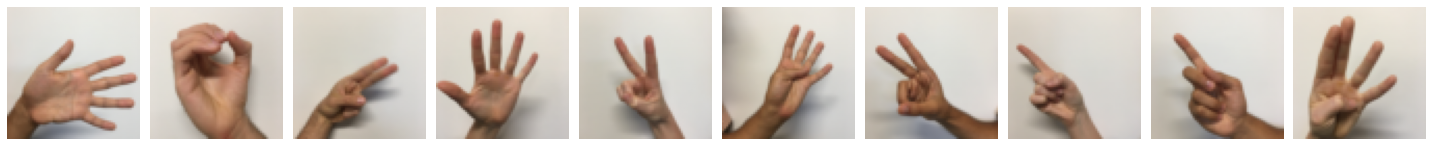

In [ ]:
# Shows the images
plotImages(X_train, Y_train_orig)

In [ ]:
def identity_block(X, f, filters, stage, block):

  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'
  
  f1, f2, f3 = filters

  bn_axis = 3

  X_skip_connection = X

  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)
  
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'
    
    f1, f2, f3 = filters
    
    bn_axis = 3

    X_skip_connection = X
 
    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)
 
    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    # Tahap 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Tahap 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Tahap 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Tahap 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Tahap 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34/34 [==============================] - 194s 5s/step - loss: 1.8266 - accuracy: 0.4713
Epoch 2/20
34/34 [==============================] - 192s 6s/step - loss: 0.6448 - accuracy: 0.7759
Epoch 3/20
34/34 [==============================] - 186s 5s/step - loss: 0.5320 - accuracy: 0.8417
Epoch 4/20
34/34 [==============================] - 186s 5s/step - loss: 0.2855 - accuracy: 0.8972
Epoch 5/20
34/34 [==============================] - 188s 6s/step - loss: 0.3545 - accuracy: 0.8991
Epoch 6/20
34/34 [==============================] - 191s 6s/step - loss: 0.2191 - accuracy: 0.9361
Epoch 7/20
34/34 [==============================] - 189s 6s/step - loss: 0.1309 - accuracy: 0.9574
Epoch 8/20
34/34 [==============================] - 189s 6s/step - loss: 0.0624 - accuracy: 0.9787
Epoch 9/20
34/34 [==============================] - 192s 6s/step - loss: 0.0450 - accuracy: 0.9833
Epoch 10/20
34/34 [==============================] - 188s 6s/step - loss: 0.1013 - accuracy: 0.9741
Epoch 11/

In [ ]:
model.save('RESNET50.h5')

In [ ]:
predictions = model.evaluate(X_test, Y_test)
print("Loss = " + str(predictions[0]))
print("Test Accuracy = " + str(predictions[1]))

4/4 [==============================] - 3s 445ms/step - loss: 1.2145 - accuracy: 0.6750
Loss = 1.2144526243209839
Test Accuracy = 0.675000011920929


In [ ]:
new_model = load_model('RESNET50.h5')
predictions = new_model.evaluate(X_test, Y_test)
print(predictions)

4/4 [==============================] - 3s 389ms/step - loss: 1.2145 - accuracy: 0.6750
[1.2144526243209839, 0.675000011920929]
